In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            # Output: (ngf*8) x 6 x 4
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=(6, 4), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size: (ngf*8) x 6 x 4
            # Output: (ngf*4) x 12 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size: (ngf*4) x 12 x 8
            # Output: (ngf*2) x 24 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size: (ngf*2) x 24 x 16
            # Output: (ngf) x 48 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size: (ngf) x 48 x 32
            # Output: (nc) x 96 x 64
            nn.ConvTranspose2d(ngf, nc, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
            # Final output size: (nc) x 96 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 96 x 64
            # Output: (ndf) x 48 x 32
            nn.Conv2d(nc, ndf, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: (ndf*2) x 24 x 16
            nn.Conv2d(ndf, ndf * 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: (ndf*4) x 12 x 8
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: (ndf*8) x 6 x 4
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Final output: 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, kernel_size=(6, 4), stride=(1, 1), padding=(0, 0), bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# create generator and discriminator
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)


In [ ]:
# load checkpoint
checkpoint = torch.load("gan_checkpoint.pth")

# load model weights
netG.load_state_dict(checkpoint['generator_state_dict'])
netD.load_state_dict(checkpoint['discriminator_state_dict'])

print("Models and optimizers loaded successfully!")

Models and optimizers loaded successfully!


In [5]:
# set to evaluation mode
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(6, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# check noise shape and distribution
noise = torch.randn(16, nz, 1, 1, device=device)
print(f"Noise shape: {noise.shape}")
print(f"Noise distribution: Mean = {noise.mean()}, Std = {noise.std()}")


Noise shape: torch.Size([16, 100, 1, 1])
Noise distribution: Mean = -0.044778142124414444, Std = 0.9906793832778931


In [17]:
i =  1000

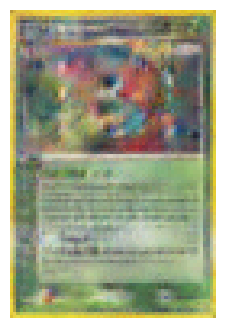

In [166]:
# Generate random noise
num_samples = 4
noise = torch.randn(num_samples, nz, 1, 1, device=device)
# Generate images
with torch.no_grad():
    generated_images = netG(noise).detach().cpu()

# Rescale images from [-1, 1] to [0, 1]
rescaled_images = (generated_images + 1) / 2  # Now in range [0, 1]
i += 1
# Display a single image
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(rescaled_images[0], (1, 2, 0)))

plt.axis("off")
plt.show()



In [ ]:
output_path = f'img_generations/generated_image_{i}.png'
save_image(rescaled_images[0], output_path)


In [571]:
j = 0

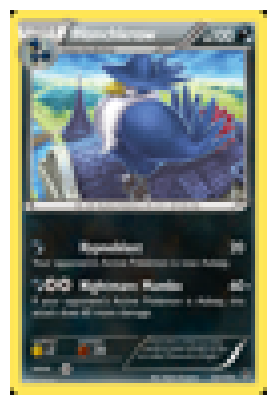

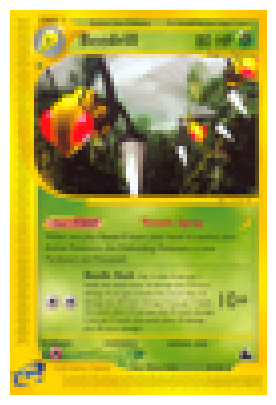

In [ ]:


# Path to your real images directory
image_dir = "images/data/"

# Desired dimensions
resize_width = 96
resize_height = 64

# List all images in the directory
image_names = os.listdir(image_dir)

# Randomly select 2 images
random_images = random.sample(image_names, 2)

# Load and resize the selected images
images = []
for image_name in random_images:
    image_path = os.path.join(image_dir, image_name)
    img = Image.open(image_path).resize((resize_height, resize_width))
    images.append(img)
    j += 1

# Display the resized images larger using matplotlib
for i, img in enumerate(images):
    plt.figure(figsize=(10, 5))  # Adjust the size as needed (width, height)
    plt.imshow(img)
    plt.axis("off")
   
    plt.show()


In [857]:
images[0].save(os.path.join("real_img_set/", f"real_img{j + 1}.png"))


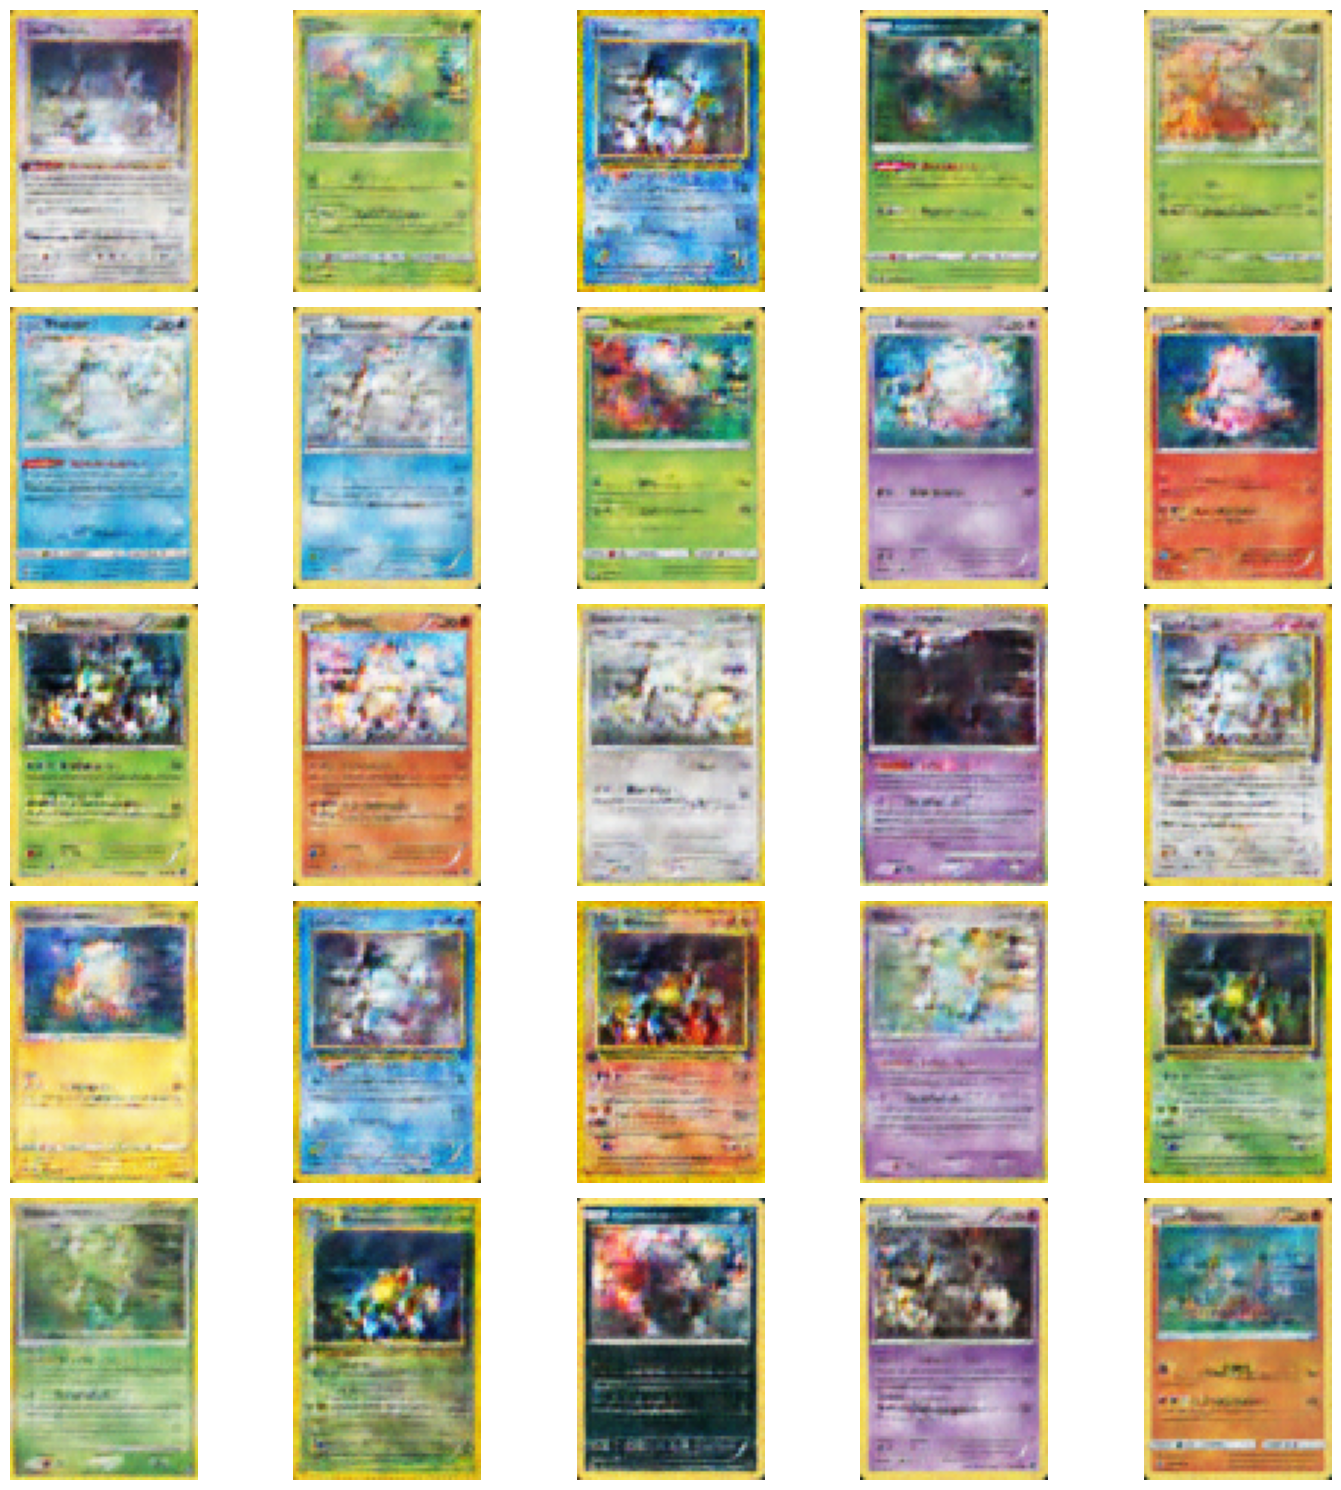

In [ ]:
# directory containing the images
output_dir = 'img_generations/'
images = [f for f in os.listdir(output_dir) if f.endswith('.png')]

# set up a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

# Iterate over the images and the axes to display them
for img_path, ax in zip(images, axes):
    img = Image.open(os.path.join(output_dir, img_path))
    ax.imshow(img)
    ax.axis('off')

for i in range(len(images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
